https://pubs.rsna.org/doi/epdf/10.1148/radiol.2015151169
https://pmc.ncbi.nlm.nih.gov/articles/PMC9374044/pdf/jnm222893.pdf

In [141]:
# Radiomics package
from radiomics import featureextractor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import metrics
from sklearn import preprocessing
import xgboost as xgb
import SimpleITK as sitk
import os
import pydicom
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import ast

Prendendo le maschere, 
Sulla multiphase, per ciascun paziente, prendi la maschera e fai un instogramma delle intensità,
per ciascuna fase calcola media/mediana/deviazione standard **x**

Guardare il range delle intensità per le immagini **x**

Salvare in nifti anche le roi originali non processsate **x**

istogrammi sull'intero solido della t2 fse, non solo maschera, prima e dopo robust scaling **x**

plottare l'andamento della media nelle 5 fasi per la multiphase  **x**

Nella documentazione delle feature di shape (Radiomic Shape class, la descrizione è li) si spiega perchè risolvere il problema dei buchi

(fare prima gli istogrammi) prima di effetuare il fill holes fai una piccola binary_dilation di 1 voxel **x**

calcolare la curva ROC nel notebook della radiomica, per farlo usare predict_proba anzichè predict **x**

per la fase di training, tenere 20 lesioni e allenare con k fold 4/5 classificatori. Una volta allenati, usarli per classificare il test set e fare la media delle predizione **x**

provare xgboost **x**

Provare le features a blocchi

- first order, shape 3d (di base)

- Uno alla volta: GLSZM, GLCM e poi le rimanenti

# Utility functions

## Open dicom folder

In [142]:
def read_dicomdir(dir_path: str) -> list:
    # opening the dicom files in the dir
    dicom_files = [
        os.path.join(dir_path, f) 
        for f in os.listdir(dir_path)
    ]
    
    # Sort the files based on slice location (for this patient is already done)
    dicom_files.sort(key=lambda x: pydicom.dcmread(x).InstanceNumber)
    
    # read the actual dicom files
    slices = [pydicom.dcmread(f) for f in dicom_files]
    
    return slices

## Reconstruct 3d shape

In [143]:
def get_3d_shape(dicom_slices: list) -> np.ndarray:
    pixel_arrays = [s.pixel_array for s in dicom_slices]

    # stack the slices to create a 3d array
    volume_3d = np.stack(pixel_arrays, axis=0)
    
    # flip the dicom on the vertical axis
    return volume_3d[:, ::-1, :]

## Plot the model classification results

In [166]:
def show_model_performances(y_test, y_predicted):
    print(metrics.classification_report(y_test, np.argmax(y_predicted, axis=1)))

    fpr, tpr, thresholds = metrics.roc_curve(
        y_test, 
        [ 
            prediction_scores[1] 
            for prediction_scores in y_predicted
        ]
    )
    roc_auc = metrics.auc(fpr, tpr)

    metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()

    cm = metrics.confusion_matrix(y_test, np.argmax(y_predicted, axis=1))
    metrics.ConfusionMatrixDisplay(cm, display_labels=["benign", "malign"]).plot()
    plt.show()

# Load up lesions dataframe

In [5]:
df = pd.read_csv("/media/bendico765/Crucial X9/MRI Lesions/lesions_df.csv", index_col=0)

#df["z_indexes"] = df["z_indexes"].apply(ast.literal_eval)

# get pixel spacing and slice thickness for each image
df["Pixel Spacing"] = [ float(read_dicomdir(dicom_path)[0].PixelSpacing[0]) for dicom_path in df["Registered Ax T2 FSE path"] ]
df["Slice Thickness"] = [ float(read_dicomdir(dicom_path)[0].SliceThickness) for dicom_path in df["Registered Ax T2 FSE path"] ]

In [6]:
df

,Patient ID,tumor/benign,Registered Ax T2 FSE path,Slice Location,Breast,z_indexes,y_indexes,x_indexes,z_offset,y_offset,x_offset,Roi mask Filepath,Cleaned Roi mask Filepath,Pixel Spacing,Slice Thickness,RobustScaled Registered Ax T2 FSE path
0,AMBL-001,1.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-60.85,L,"[82, 83, 84, 85, 86, 87]","[172, 173, 174, 175, 176, 177, 178, 179, 180, ...","[142, 143, 144, 145, 146, 147, 148, 149, 150, ...",6,42,23,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...
1,AMBL-001,1.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-56.85,R,"[82, 83, 84, 85]","[188, 189, 190, 191, 192, 193, 194, 195, 196, ...","[360, 361, 362, 363, 364, 365, 366, 367, 368, ...",4,46,17,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...
12,AMBL-003,1.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-2.76,R,"[49, 50, 51, 52, 53, 54, 55]","[178, 179, 180, 181, 182, 183, 184, 185, 186, ...","[357, 358, 359, 360, 361, 362, 363, 364, 365, ...",7,40,21,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...
18,AMBL-004,0.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-51.98,L,"[81, 82, 83, 84, 85]","[163, 164, 165, 166, 167, 168, 169, 170, 171, ...","[147, 148, 149, 150, 151, 152, 153, 154, 155, ...",5,18,13,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...
24,AMBL-005,1.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-28.46,R,"[54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 6...","[194, 195, 196, 197, 198, 199, 200, 201, 202, ...","[379, 380, 381, 382, 383, 384, 385, 386, 387, ...",13,55,47,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1179,AMBL-629,0.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,1.93,R,"[55, 56, 57]","[159, 160, 161, 162, 163, 164, 165, 166, 167, ...","[391, 392, 393, 394, 395, 396, 397, 398, 399, ...",3,21,10,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6445,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...
1180,AMBL-629,0.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-48.07,R,"[81, 82]","[147, 148, 149, 150, 151, 152, 153, 154, 155, ...","[373, 374, 375, 376, 377, 378, 379, 380, 381, ...",2,17,14,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6445,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...
1181,AMBL-629,0.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-32.07,R,"[73, 74, 75]","[156, 157, 158, 159, 160, 161, 162, 163, 164, ...","[338, 339, 340, 341, 342, 343, 344, 345, 346, ...",3,20,12,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6445,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...
1188,AMBL-631,1.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,33.93,L,"[37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 4...","[143, 144, 145, 146, 147, 148, 149, 150, 151, ...","[99, 100, 101, 102, 103, 104, 105, 106, 107, 1...",22,85,87,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...


In [7]:
df.to_csv("/media/bendico765/Crucial X9/MRI Lesions/lesions_df.csv")

# Preprocessing

## Robust scaling

In [7]:
robust_scaling = lambda a: (a - np.median(a.flatten()))/scipy.stats.iqr(a.flatten())

### Patient AMBL-001

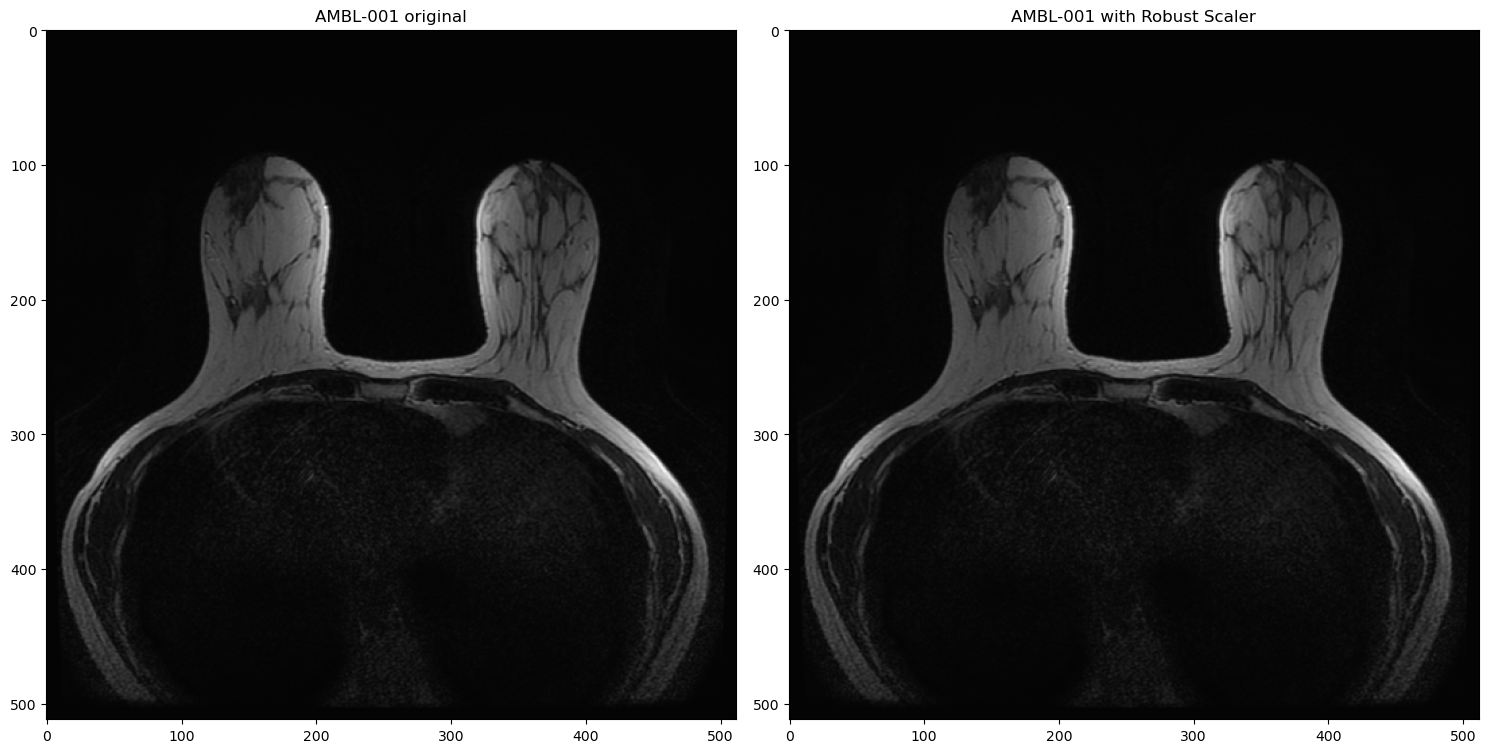

In [8]:
volume_3d = get_3d_shape(read_dicomdir(df.at[0, "Registered Ax T2 FSE path"]))
scaled_volume = robust_scaling(volume_3d)

fig, axes = plt.subplots(1, 2, figsize=(15, 15))

# First subplot
axes[0].imshow(volume_3d[83, :, :], cmap=plt.cm.gray)
axes[0].set_title('AMBL-001 original')

# Second subplot
axes[1].imshow(scaled_volume[83, :, :], cmap=plt.cm.gray)
axes[1].set_title('AMBL-001 with Robust Scaler')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

### Apply to all the patients

In [9]:
target_directory = "/media/bendico765/Crucial X9/MRI Lesions/RobustScaledMRI"
scaled_dicoms = []

try:
    os.mkdir(f"{target_directory}")
except FileExistsError:
    pass
    
for _, row in df.iterrows() :
    patient_id = row["Patient ID"]
    dicom_path = row["Registered Ax T2 FSE path"]
    filepath = f"{target_directory}/{patient_id}/Registered Ax T2 FSE/{patient_id}.npy"

    print(f"Computing patient {patient_id}")
    
    scaled_dicoms.append(filepath)

    # if doesn't exist, compute it
    if( not os.path.isfile(filepath) ):
        # create the directory for the patient mri
        try:
            os.mkdir(f"{target_directory}/{patient_id}")
            os.mkdir(f"{target_directory}/{patient_id}/Registered Ax T2 FSE")
        except FileExistsError:
            pass
        
        volume_3d = get_3d_shape(read_dicomdir(dicom_path))
        np.save(filepath, robust_scaling(volume_3d))

df["RobustScaled Registered Ax T2 FSE path"] = scaled_dicoms

Computing patient AMBL-001
Computing patient AMBL-001
Computing patient AMBL-003
Computing patient AMBL-004
Computing patient AMBL-005
Computing patient AMBL-007
Computing patient AMBL-008
Computing patient AMBL-008
Computing patient AMBL-009
Computing patient AMBL-010
Computing patient AMBL-011
Computing patient AMBL-011
Computing patient AMBL-013
Computing patient AMBL-013
Computing patient AMBL-016
Computing patient AMBL-016
Computing patient AMBL-016
Computing patient AMBL-018
Computing patient AMBL-018
Computing patient AMBL-018
Computing patient AMBL-022
Computing patient AMBL-023
Computing patient AMBL-023
Computing patient AMBL-024
Computing patient AMBL-024
Computing patient AMBL-025
Computing patient AMBL-026
Computing patient AMBL-026
Computing patient AMBL-026
Computing patient AMBL-028
Computing patient AMBL-029
Computing patient AMBL-029
Computing patient AMBL-031
Computing patient AMBL-031
Computing patient AMBL-032
Computing patient AMBL-033
Computing patient AMBL-034
C

In [10]:
df.head()

,Patient ID,tumor/benign,Registered Ax T2 FSE path,Slice Location,Breast,z_indexes,y_indexes,x_indexes,z_offset,y_offset,x_offset,Roi mask Filepath,Cleaned Roi mask Filepath,Pixel Spacing,Slice Thickness,RobustScaled Registered Ax T2 FSE path
0,AMBL-001,1.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-60.85,L,"[82, 83, 84, 85, 86, 87]","[172, 173, 174, 175, 176, 177, 178, 179, 180, ...","[142, 143, 144, 145, 146, 147, 148, 149, 150, ...",6,42,23,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,0.6641,/media/bendico765/Crucial X9/MRI Lesions/Robus...
1,AMBL-001,1.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-56.85,R,"[82, 83, 84, 85]","[188, 189, 190, 191, 192, 193, 194, 195, 196, ...","[360, 361, 362, 363, 364, 365, 366, 367, 368, ...",4,46,17,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,0.6641,/media/bendico765/Crucial X9/MRI Lesions/Robus...
12,AMBL-003,1.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-2.76,R,"[49, 50, 51, 52, 53, 54, 55]","[178, 179, 180, 181, 182, 183, 184, 185, 186, ...","[357, 358, 359, 360, 361, 362, 363, 364, 365, ...",7,40,21,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,0.6641,/media/bendico765/Crucial X9/MRI Lesions/Robus...
18,AMBL-004,0.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-51.98,L,"[81, 82, 83, 84, 85]","[163, 164, 165, 166, 167, 168, 169, 170, 171, ...","[147, 148, 149, 150, 151, 152, 153, 154, 155, ...",5,18,13,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,0.6641,/media/bendico765/Crucial X9/MRI Lesions/Robus...
24,AMBL-005,1.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-28.46,R,"[54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 6...","[194, 195, 196, 197, 198, 199, 200, 201, 202, ...","[379, 380, 381, 382, 383, 384, 385, 386, 387, ...",13,55,47,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,0.6641,/media/bendico765/Crucial X9/MRI Lesions/Robus...


In [12]:
df.to_csv("/media/bendico765/Crucial X9/MRI Lesions/lesions_df.csv")

# Pyradiomics

## Define the radiomics feature

In [145]:
shape_features = [
    'original_shape_Elongation',
    'original_shape_Flatness',
    'original_shape_LeastAxisLength',
    'original_shape_MajorAxisLength',
    'original_shape_Maximum2DDiameterColumn',
    'original_shape_Maximum2DDiameterRow',
    'original_shape_Maximum2DDiameterSlice',
    'original_shape_Maximum3DDiameter',
    'original_shape_MeshVolume',
    'original_shape_MinorAxisLength',
    'original_shape_Sphericity',
    'original_shape_SurfaceArea',
    'original_shape_SurfaceVolumeRatio',
    'original_shape_VoxelVolume'
]

first_order_featues = [
    'original_firstorder_10Percentile',
    'original_firstorder_90Percentile',
    'original_firstorder_Entropy',
    'original_firstorder_InterquartileRange',
    'original_firstorder_Kurtosis',
    'original_firstorder_Maximum',
    'original_firstorder_MeanAbsoluteDeviation',
    'original_firstorder_Mean',
    'original_firstorder_Median',
    'original_firstorder_Minimum',
    'original_firstorder_Range',
    'original_firstorder_RobustMeanAbsoluteDeviation',
    'original_firstorder_RootMeanSquared',
    'original_firstorder_Skewness',
    'original_firstorder_TotalEnergy',
    'original_firstorder_Uniformity',
    'original_firstorder_Variance'
]

glcm_features = [
    'original_glcm_Autocorrelation',
    'original_glcm_ClusterProminence',
    'original_glcm_ClusterShade',
    'original_glcm_ClusterTendency',
    'original_glcm_Contrast',
    'original_glcm_Correlation',
    'original_glcm_DifferenceAverage',
    'original_glcm_DifferenceEntropy',
    'original_glcm_DifferenceVariance',
    'original_glcm_Id',
    'original_glcm_Idm',
    'original_glcm_Idmn',
    'original_glcm_Idn',
    'original_glcm_Imc1',
    'original_glcm_Imc2',
    'original_glcm_InverseVariance',
    'original_glcm_JointAverage',
    'original_glcm_JointEnergy',
    'original_glcm_JointEntropy',
    'original_glcm_MCC',
    'original_glcm_MaximumProbability',
    'original_glcm_SumAverage',
    'original_glcm_SumEntropy',
    'original_glcm_SumSquares'
]

gldm_features = [
    'original_gldm_DependenceEntropy',
    'original_gldm_DependenceNonUniformity',
    'original_gldm_DependenceNonUniformityNormalized',
    'original_gldm_DependenceVariance',
    'original_gldm_GrayLevelNonUniformity',
    'original_gldm_GrayLevelVariance',
    'original_gldm_HighGrayLevelEmphasis',
    'original_gldm_LargeDependenceEmphasis',
    'original_gldm_LargeDependenceHighGrayLevelEmphasis',
    'original_gldm_LargeDependenceLowGrayLevelEmphasis',
    'original_gldm_LowGrayLevelEmphasis',
    'original_gldm_SmallDependenceEmphasis',
    'original_gldm_SmallDependenceHighGrayLevelEmphasis',
    'original_gldm_SmallDependenceLowGrayLevelEmphasis'
]

glrlm_features = [
    'original_glrlm_GrayLevelNonUniformity',
    'original_glrlm_GrayLevelNonUniformityNormalized',
    'original_glrlm_GrayLevelVariance',
    'original_glrlm_HighGrayLevelRunEmphasis',
    'original_glrlm_LongRunEmphasis',
    'original_glrlm_LongRunHighGrayLevelEmphasis',
    'original_glrlm_LongRunLowGrayLevelEmphasis',
    'original_glrlm_LowGrayLevelRunEmphasis',
    'original_glrlm_RunEntropy',
    'original_glrlm_RunLengthNonUniformity',
    'original_glrlm_RunLengthNonUniformityNormalized',
    'original_glrlm_RunPercentage',
    'original_glrlm_RunVariance',
    'original_glrlm_ShortRunEmphasis',
    'original_glrlm_ShortRunHighGrayLevelEmphasis',
    'original_glrlm_ShortRunLowGrayLevelEmphasis'
]

glszm_features = [
    'original_glszm_GrayLevelNonUniformity',
    'original_glszm_GrayLevelNonUniformityNormalized',
    'original_glszm_GrayLevelVariance',
    'original_glszm_HighGrayLevelZoneEmphasis',
    'original_glszm_LargeAreaEmphasis',
    'original_glszm_LargeAreaHighGrayLevelEmphasis',
    'original_glszm_LargeAreaLowGrayLevelEmphasis',
    'original_glszm_LowGrayLevelZoneEmphasis',
    'original_glszm_SizeZoneNonUniformity',
    'original_glszm_SizeZoneNonUniformityNormalized',
    'original_glszm_SmallAreaEmphasis',
    'original_glszm_SmallAreaHighGrayLevelEmphasis',
    'original_glszm_SmallAreaLowGrayLevelEmphasis',
    'original_glszm_ZoneEntropy',
    'original_glszm_ZonePercentage',
    'original_glszm_ZoneVariance'
]

ngtdm_features = [
    'original_ngtdm_Busyness',
    'original_ngtdm_Coarseness',
    'original_ngtdm_Complexity',
    'original_ngtdm_Contrast',
    'original_ngtdm_Strength'
]

features = shape_features + first_order_featues + glcm_features + gldm_features + glrlm_features + glszm_features + ngtdm_features

In [4]:
def get_radiomics_dataset(df):
    """
    Given the lesions dataframe, iterate over each lesion
    """
    for _, row in df.iterrows(): # iterate over all lesions
        patient_id = row["Patient ID"]

        # get patient data
        label = row["tumor/benign"]
        volume_3d = np.load(row["RobustScaled Registered Ax T2 FSE path"])
        pixel_spacing = row["Pixel Spacing"]
        slice_thickness = row["Slice Thickness"]
        roi = np.load(row["Cleaned Roi mask Filepath"])
        z_indexes = row["z_indexes"]

        extractor = featureextractor.RadiomicsFeatureExtractor()

        # create the SITK image of the MRI
        sitk_img = sitk.GetImageFromArray(volume_3d)
        sitk_img.SetSpacing( (pixel_spacing, pixel_spacing, slice_thickness) )

        # create the SITK image of the lesion mask
        sitk_mask = sitk.GetImageFromArray(roi)
        sitk_mask.SetSpacing( (pixel_spacing,pixel_spacing, slice_thickness) )

        # extract the radiomic features
        try:
            extracted_features = extractor.execute(sitk_img, sitk_mask)
        except ValueError as e:
            print(f"[{patient_id}] Skipping error: {e}")
            continue

        # return the features plus the label and the patient id
        l = [ 
            value.item() 
            for key, value in extracted_features.items() if key in features
        ]
        l.insert(0, label)
        l.insert(0, patient_id)
        yield l

## Create a dataset

In [ ]:
iterator = get_radiomics_dataset(df)
radiomics_df = pd.DataFrame(
    iterator,
    columns = ["Patient id", "tumor/benign"] + features
)

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

In [ ]:
radiomics_df

In [ ]:
radiomics_df.to_csv("/media/bendico765/Crucial X9/MRI Lesions/radiomics.csv")

## Prediction

In [174]:
radiomics_df = pd.read_csv("/media/bendico765/Crucial X9/MRI Lesions/radiomics.csv", index_col=0)

In [179]:
radiomics_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 164 entries, 0 to 163
Columns: 108 entries, Patient id to original_ngtdm_Strength
dtypes: float64(107), object(1)
memory usage: 139.7+ KB


In [175]:
X = radiomics_df[features].values
y = radiomics_df["tumor/benign"].values

### Data preparation

In [176]:
# number of splits for the k-fold cross validator
N_SPLITS = 5

In [177]:
# take 20 samples (10 benign and 10 tumor) as a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 20, stratify = y, random_state = 0)

# split the remaining data in train and test set
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3, stratify = y_train, random_state = 0)

### Random Forest Classifier

In [171]:
classifiers = []
total_accuracy = 0
total_f1 = 0

for index, (train_index, test_index) in enumerate(StratifiedKFold(N_SPLITS).split(X_train, y_train)):
    classifier = RandomForestClassifier(
        n_estimators = 100, 
        class_weight="balanced", 
        random_state = index).fit(X_train[train_index], y_train[train_index])

    y_predicted = classifier.predict_proba(X_train[test_index])
    
    accuracy_score = metrics.accuracy_score(y_train[test_index], np.argmax(y_predicted, axis=1))
    f1_score = metrics.f1_score(y_train[test_index], np.argmax(y_predicted, axis=1))
    print(f"Fold: {index} Accuracy: { accuracy_score:.2f} F1-score: {f1_score:.2f}")

    total_accuracy += accuracy_score
    total_f1 += f1_score
    
    classifiers.append(classifier)

Fold: 0 Accuracy: 0.59 F1-score: 0.54
Fold: 1 Accuracy: 0.79 F1-score: 0.77
Fold: 2 Accuracy: 0.69 F1-score: 0.69
Fold: 3 Accuracy: 0.69 F1-score: 0.71
Fold: 4 Accuracy: 0.64 F1-score: 0.62


In [172]:
ensemble_prediction = np.full((20,2) , 0, dtype="float64")

for classifier in classifiers:
    ensemble_prediction += classifier.predict_proba(X_test)

ensemble_prediction /= N_SPLITS

              precision    recall  f1-score   support

         0.0       0.89      0.80      0.84        10
         1.0       0.82      0.90      0.86        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



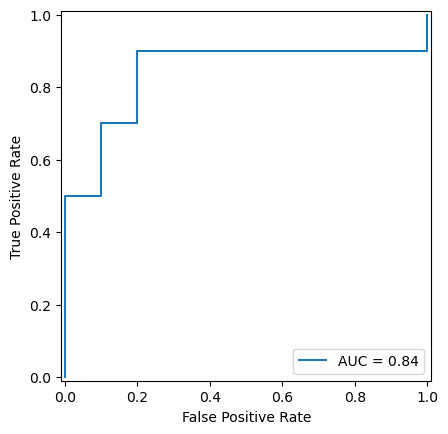

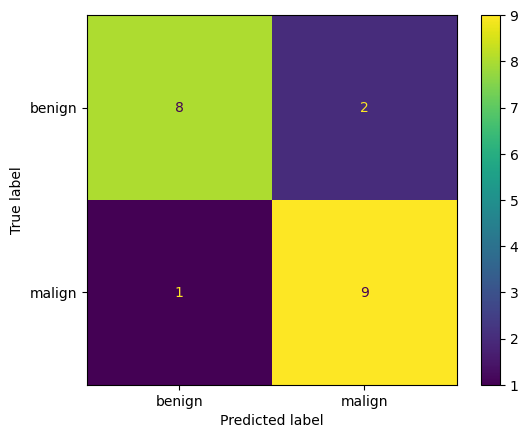

In [173]:
show_model_performances(y_test, ensemble_prediction)

### Gradient Booster

In [153]:
classifiers = []

for index, (train_index, test_index) in enumerate(StratifiedKFold(N_SPLITS).split(X_train, y_train)):
    classifier = GradientBoostingClassifier(
        n_estimators = 100, 
        random_state = index).fit(X_train[train_index], y_train[train_index])

    y_predicted = classifier.predict_proba(X_train[test_index])
    
    accuracy_score = metrics.accuracy_score(y_train[test_index], np.argmax(y_predicted, axis=1))
    f1_score = metrics.f1_score(y_train[test_index], np.argmax(y_predicted, axis=1))
    print(f"Fold: {index} Accuracy: { accuracy_score:.2f} F1-score: {f1_score:.2f}")
    
    classifiers.append(classifier)

Fold: 0 Accuracy: 0.55 F1-score: 0.48
Fold: 1 Accuracy: 0.72 F1-score: 0.71
Fold: 2 Accuracy: 0.79 F1-score: 0.80
Fold: 3 Accuracy: 0.69 F1-score: 0.73
Fold: 4 Accuracy: 0.68 F1-score: 0.61


In [154]:
ensemble_prediction = np.full((20,2) , 0, dtype="float64")

for classifier in classifiers:
    ensemble_prediction += classifier.predict_proba(X_test)

ensemble_prediction /= N_SPLITS

              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90        10
         1.0       0.90      0.90      0.90        10

    accuracy                           0.90        20
   macro avg       0.90      0.90      0.90        20
weighted avg       0.90      0.90      0.90        20



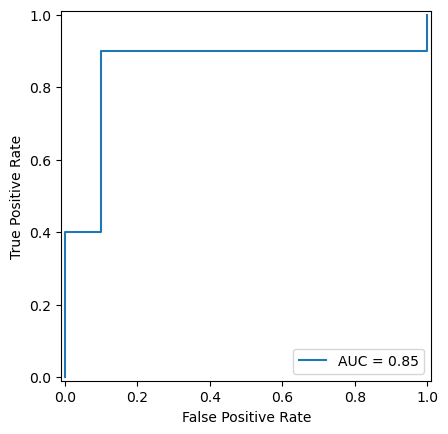

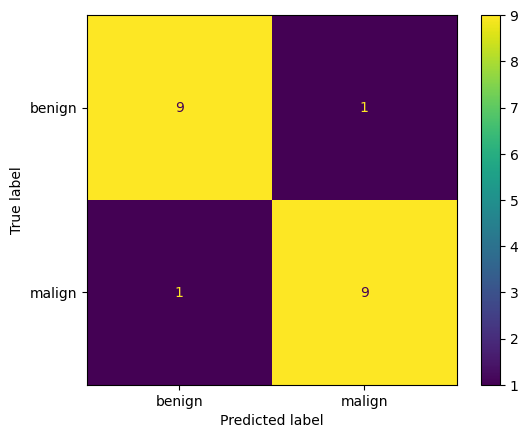

In [155]:
show_model_performances(y_test, ensemble_prediction)

#### Inspect the results

In [156]:
predictions = [
    np.argmax(classifier.predict_proba(X_test), axis=1)
    for classifier in classifiers
]

for real_label, pred1, pred2, pred3, pred4, pred5 in zip(y_test, predictions[0], predictions[1], predictions[2], predictions[3], predictions[4]):
    print(f"Real label: {real_label} Predictions: {pred1} {pred2} {pred3} {pred4} {pred5}")

Real label: 1.0 Predictions: 1 0 0 1 1
Real label: 0.0 Predictions: 0 0 0 0 0
Real label: 1.0 Predictions: 1 1 1 1 1
Real label: 0.0 Predictions: 0 0 0 0 0
Real label: 0.0 Predictions: 0 0 0 0 0
Real label: 1.0 Predictions: 1 1 1 1 1
Real label: 0.0 Predictions: 0 0 0 0 0
Real label: 1.0 Predictions: 1 1 1 1 1
Real label: 1.0 Predictions: 1 1 1 1 1
Real label: 0.0 Predictions: 1 1 1 1 1
Real label: 1.0 Predictions: 1 1 1 1 1
Real label: 0.0 Predictions: 0 0 0 0 0
Real label: 0.0 Predictions: 1 0 0 0 0
Real label: 1.0 Predictions: 1 1 1 1 1
Real label: 1.0 Predictions: 0 0 0 0 0
Real label: 0.0 Predictions: 0 0 0 0 0
Real label: 0.0 Predictions: 0 0 0 0 0
Real label: 0.0 Predictions: 0 0 0 0 0
Real label: 1.0 Predictions: 1 1 1 0 1
Real label: 1.0 Predictions: 1 1 1 1 1


In [157]:
for classifier in classifiers:
    y_predicted = classifier.predict_proba(X_test)

    accuracy_score = metrics.accuracy_score(y_test, np.argmax(y_predicted, axis=1))
    f1_score = metrics.f1_score(y_test, np.argmax(y_predicted, axis=1))
    print(f"Fold: {index} Accuracy: { accuracy_score:.2f} F1-score: {f1_score:.2f}")

Fold: 4 Accuracy: 0.85 F1-score: 0.86
Fold: 4 Accuracy: 0.85 F1-score: 0.84
Fold: 4 Accuracy: 0.85 F1-score: 0.84
Fold: 4 Accuracy: 0.85 F1-score: 0.84
Fold: 4 Accuracy: 0.90 F1-score: 0.90


### XGBoost

In [158]:
classifiers = []

for index, (train_index, test_index) in enumerate(StratifiedKFold(N_SPLITS).split(X_train, y_train)):
    classifier = xgb.XGBClassifier( 
        random_state = index).fit(X_train[train_index], y_train[train_index])

    y_predicted = classifier.predict_proba(X_train[test_index])
    
    accuracy_score = metrics.accuracy_score(y_train[test_index], np.argmax(y_predicted, axis=1))
    f1_score = metrics.f1_score(y_train[test_index], np.argmax(y_predicted, axis=1))
    print(f"Fold: {index} Accuracy: { accuracy_score:.2f} F1-score: {f1_score:.2f}")
    
    classifiers.append(classifier)

Fold: 0 Accuracy: 0.66 F1-score: 0.64
Fold: 1 Accuracy: 0.69 F1-score: 0.64
Fold: 2 Accuracy: 0.69 F1-score: 0.69
Fold: 3 Accuracy: 0.62 F1-score: 0.67
Fold: 4 Accuracy: 0.71 F1-score: 0.67


In [159]:
ensemble_prediction = np.full((20,2) , 0, dtype="float64")

for classifier in classifiers:
    ensemble_prediction += classifier.predict_proba(X_test)

ensemble_prediction /= N_SPLITS

              precision    recall  f1-score   support

         0.0       0.89      0.80      0.84        10
         1.0       0.82      0.90      0.86        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



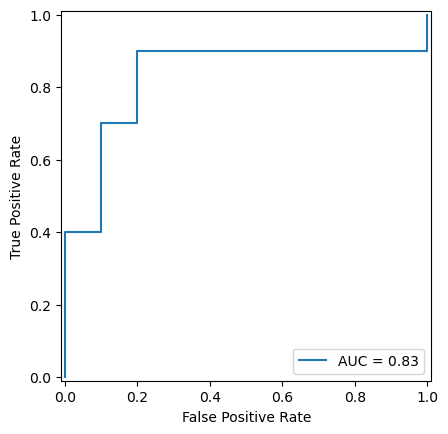

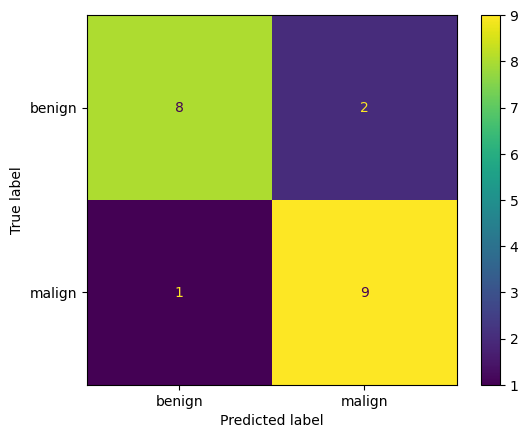

In [160]:
show_model_performances(y_test, ensemble_prediction)

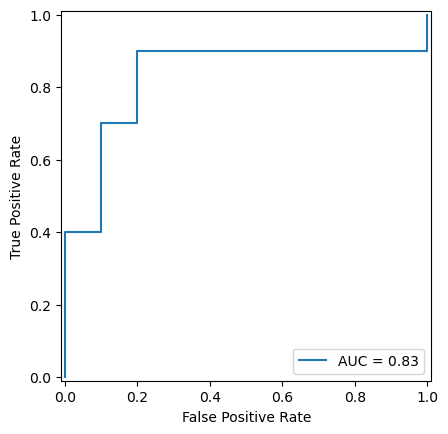

In [161]:
fpr, tpr, thresholds = metrics.roc_curve(
    y_test, 
    [ prob[1] for prob in ensemble_prediction]
)
roc_auc = metrics.auc(fpr, tpr)

metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()